In [168]:
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt
import json


In [169]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from pts.model.tempflow import TempFlowEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from gluonts.dataset.util import to_pandas

In [170]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepare data set

In [171]:
dataset = get_dataset("solar_nips", regenerate=False)

/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


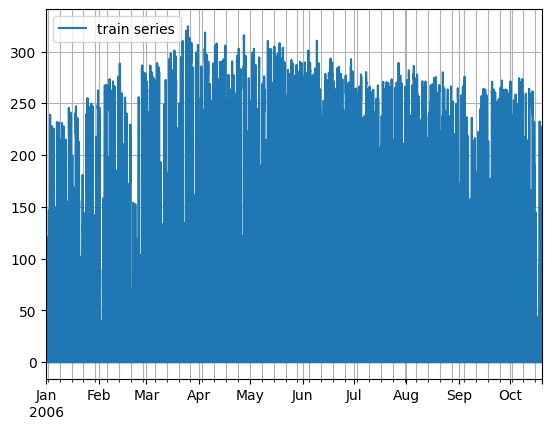

In [172]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


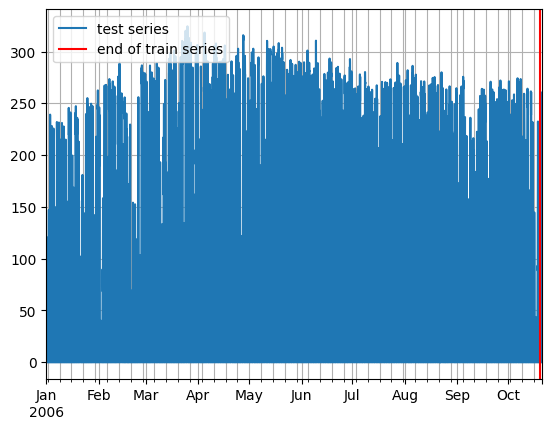

In [173]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [174]:

print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 24
Recommended prediction horizon: 24
Frequency of the time series: H


In [175]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [176]:
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

In [177]:
dataset_train = train_grouper(dataset.train)
# dataset_test = test_grouper(dataset.test)

/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:106: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp + (len(data[FieldName.TARGET]) - 1) * timestamp.freq,
/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:108: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self.frequency = timestamp.freq
/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:217: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,
/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:166: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,


# Custom Dataset

In [178]:
import os
os.getcwd()

'/Users/jangsuhyeok/Desktop/hackaton_1128/multivariate_flow/pytorch-ts-master/examples'

In [179]:
import pickle
with open("../../../preprocess_data/pickle_final2.pkl", 'rb') as f:
    df = pickle.load(f)
df

,GNI,GNI 증감률,전체_사교육비,초등학교_사교육비,중학교_사교육비,고등학교_사교육비,GDP디플레이터_증감률,총지수_증감률,생활물가지수_증감률,신선식품지수_증감률,...,니코틴의존,니코틴금단,주요우울장애,기분부전장애,강박장애,공황장애,광장공포증,사회공포증,범불안장애,특정공포증
1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-01-01,136.0,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-01,138.0,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01,149.0,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-01-01,157.0,5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01,3532.0,1.1,29.1,26.3,31.2,32.1,0.5,1.5,1.6,3.6,...,2.22,0.94,1.58,0.2,0.28,0.16,0.2,0.32,0.4,3.36
2019-01-01,3532.0,0.0,32.1,29.0,33.8,36.5,-0.8,0.4,0.2,-5.1,...,2.28,0.96,1.62,0.2,0.22,0.14,0.2,0.28,0.4,2.94
2020-01-01,3530.0,-0.1,30.2,23.5,34.2,39.6,1.6,0.5,0.4,9.0,...,2.34,0.98,1.66,0.2,0.16,0.12,0.2,0.24,0.4,2.52
2021-01-01,3659.0,3.7,36.7,32.8,39.2,41.9,2.8,2.5,3.2,6.2,...,2.40,1.00,1.70,0.2,0.10,0.10,0.2,0.20,0.4,2.10


In [237]:
df_nona = df.dropna()
df_nona = df_nona.astype(float)

In [238]:
df_nona.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2010-01-01 to 2022-01-01
Data columns (total 64 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   GNI                      13 non-null     float64
 1   GNI 증감률                  13 non-null     float64
 2   전체_사교육비                  13 non-null     float64
 3   초등학교_사교육비                13 non-null     float64
 4   중학교_사교육비                 13 non-null     float64
 5   고등학교_사교육비                13 non-null     float64
 6   GDP디플레이터_증감률             13 non-null     float64
 7   총지수_증감률                  13 non-null     float64
 8   생활물가지수_증감률               13 non-null     float64
 9   신선식품지수_증감률               13 non-null     float64
 10  조혼인율                     13 non-null     float64
 11  조이혼율                     13 non-null     float64
 12  여성초혼 연령                  13 non-null     float64
 13  국공립 어린이집 비율              13 non-null     float64
 14  여성경제 활동참

In [242]:
df['GNI']['2010']

2010-01-01    2808.0
Name: GNI, dtype: float64

In [244]:
# 월별 데이터를 저장할 빈 데이터프레임 생성
monthly_df = pd.DataFrame()

# 시작 연도와 마지막 연도 추출
start_year = df_nona.index.min().year
end_year = df_nona.index.max().year

# 각 열에 대해서 연도별로 루프 돌며 선형 내삽하여 월별 데이터 생성
for column in df.columns:
    monthly_data = pd.DataFrame()
    for year in range(start_year, end_year + 1): #2010~2022
        year_data = df_nona[column][str(year)]
        if year == start_year:
            # 첫 해는 그대로 복사
            monthly_data = pd.concat([monthly_data, year_data])
        else:
            # 나머지 해는 이전 해의 마지막 값에서 선형 내삽
            previous_year_data = df_nona[column][str(year - 1)] #2010
            start_value = previous_year_data.iloc[-1]
            end_value = year_data.iloc[0] #2011
            num_months = 12
            interpolated_values = np.linspace(start_value, end_value, num_months, endpoint=False)
            interpolated_data = pd.DataFrame(interpolated_values, columns=[column], index=pd.date_range(start=f'{year-1}-01-01', periods=num_months, freq='M'))
            monthly_data = pd.concat([monthly_data, interpolated_data])
    monthly_df[column] = monthly_data[column]

monthly_df= monthly_df[1:]

# 결과 출력
monthly_df

,GNI,GNI 증감률,전체_사교육비,초등학교_사교육비,중학교_사교육비,고등학교_사교육비,GDP디플레이터_증감률,총지수_증감률,생활물가지수_증감률,신선식품지수_증감률,...,니코틴의존,니코틴금단,주요우울장애,기분부전장애,강박장애,공황장애,광장공포증,사회공포증,범불안장애,특정공포증
2010-01-31,2808.000000,6.700000,24.000000,24.500000,25.500000,21.800000,2.700000,2.900000,3.400000,21.300000,...,3.500000,1.660,2.98,0.380000,0.580000,0.180000,0.280000,0.320000,0.140000,4.520000
2010-02-28,2810.000000,6.208333,24.000000,24.466667,25.558333,21.800000,2.583333,2.991667,3.483333,20.050000,...,3.466667,1.655,2.99,0.381667,0.581667,0.181667,0.281667,0.318333,0.136667,4.543333
2010-03-31,2812.000000,5.716667,24.000000,24.433333,25.616667,21.800000,2.466667,3.083333,3.566667,18.800000,...,3.433333,1.650,3.00,0.383333,0.583333,0.183333,0.283333,0.316667,0.133333,4.566667
2010-04-30,2814.000000,5.225000,24.000000,24.400000,25.675000,21.800000,2.350000,3.175000,3.650000,17.550000,...,3.400000,1.645,3.01,0.385000,0.585000,0.185000,0.285000,0.315000,0.130000,4.590000
2010-05-31,2816.000000,4.733333,24.000000,24.366667,25.733333,21.800000,2.233333,3.266667,3.733333,16.300000,...,3.366667,1.640,3.02,0.386667,0.586667,0.186667,0.286667,0.313333,0.126667,4.613333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,3649.083333,1.250000,39.208333,35.366667,41.883333,44.291667,1.925000,4.016667,4.833333,5.733333,...,2.400000,1.000,1.70,0.200000,0.100000,0.100000,0.200000,0.200000,0.400000,2.100000
2021-09-30,3647.666667,0.900000,39.566667,35.733333,42.266667,44.633333,1.800000,4.233333,5.066667,5.666667,...,2.400000,1.000,1.70,0.200000,0.100000,0.100000,0.200000,0.200000,0.400000,2.100000
2021-10-31,3646.250000,0.550000,39.925000,36.100000,42.650000,44.975000,1.675000,4.450000,5.300000,5.600000,...,2.400000,1.000,1.70,0.200000,0.100000,0.100000,0.200000,0.200000,0.400000,2.100000
2021-11-30,3644.833333,0.200000,40.283333,36.466667,43.033333,45.316667,1.550000,4.666667,5.533333,5.533333,...,2.400000,1.000,1.70,0.200000,0.100000,0.100000,0.200000,0.200000,0.400000,2.100000


# Monthly df

In [246]:
prediction_length = 36
freq = "M"
start = pd.Period("01-01-2010", freq='M')

In [247]:
from gluonts.dataset.common import ListDataset
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
m_train_ds = ListDataset(
    [{"target": x, "start": start.to_timestamp()} for x in np.array(monthly_df.T)[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
m_test_ds = ListDataset(
    [{"target": x, "start": start.to_timestamp()} for x in np.array(monthly_df.T)], freq=freq
)

In [248]:
entry = iter(m_train_ds)

/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


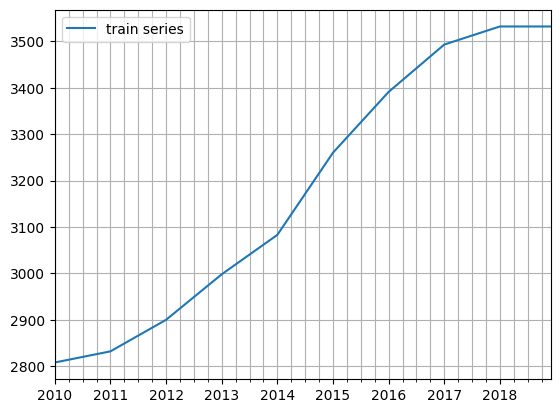

In [249]:
m_train_series = to_pandas(next(entry))
m_train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

In [250]:
entry = iter(m_test_ds)

/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


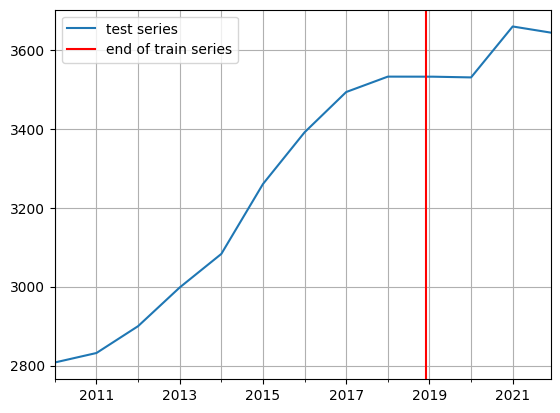

In [251]:
m_test_series = to_pandas(next(entry))
m_test_series.plot()
plt.axvline(m_train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

# Yearly Df

In [ ]:
prediction_length = 3
freq = "1A"
start = pd.Period("01-01-2010", freq='1A')

In [ ]:
np.array(df_nona.T).shape

(64, 13)

In [ ]:
np.array(df_nona.T)[:,:-3].shape

(64, 10)

In [ ]:
from gluonts.dataset.common import ListDataset
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start.to_timestamp()} for x in np.array(df_nona.T)[:, :-prediction_length]],
    freq='1A',
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start.to_timestamp()} for x in np.array(df_nona.T)], freq='1A'
)

In [ ]:
entry = iter(train_ds)

/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/common.py:338: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return timestamp.freq.rollforward(timestamp)
/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


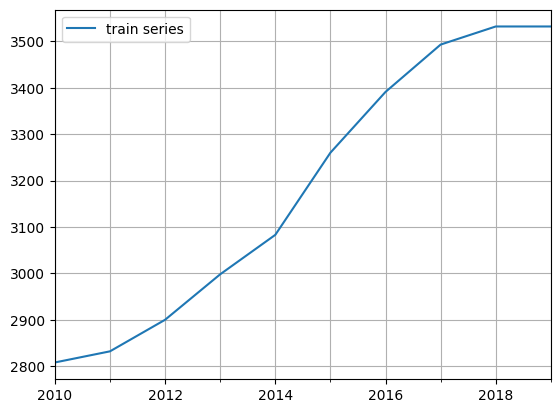

In [ ]:
train_series = to_pandas(next(entry))
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

In [ ]:
entry = iter(test_ds)

/Users/jangsuhyeok/opt/anaconda3/envs/pytlesson/lib/python3.10/site-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


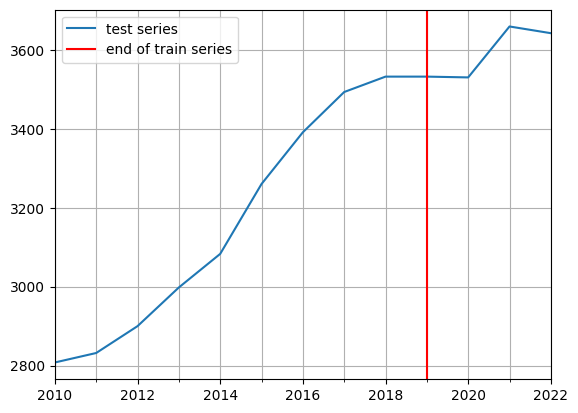

In [ ]:
test_series = to_pandas(next(entry))
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [ ]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)

Length of forecasting window in test dataset: 3


## Evaluator

In [199]:
(np.arange(20)/20.0)[1:]

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [252]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], #20분위수
                                  target_agg_funcs={'sum': np.sum})

## `GRU-Real-NVP`

In [253]:
num_time_series = len(m_train_ds.list_data)
num_time_series

64

In [277]:
m_train_ds = ListDataset(
    [{"target": x, "start": start.to_timestamp()} for x in np.array(monthly_df.T)[:, :-prediction_length]],
    freq=freq,
)

next(iter(m_train_ds))

{'target': array([2808.    , 2810.    , 2812.    , 2814.    , 2816.    , 2818.    ,
        2820.    , 2822.    , 2824.    , 2826.    , 2828.    , 2830.    ,
        2832.    , 2837.6667, 2843.3333, 2849.    , 2854.6667, 2860.3333,
        2866.    , 2871.6667, 2877.3333, 2883.    , 2888.6667, 2894.3333,
        2900.    , 2908.1667, 2916.3333, 2924.5   , 2932.6667, 2940.8333,
        2949.    , 2957.1667, 2965.3333, 2973.5   , 2981.6667, 2989.8333,
        2998.    , 3005.0833, 3012.1667, 3019.25  , 3026.3333, 3033.4167,
        3040.5   , 3047.5833, 3054.6667, 3061.75  , 3068.8333, 3075.9167,
        3083.    , 3097.75  , 3112.5   , 3127.25  , 3142.    , 3156.75  ,
        3171.5   , 3186.25  , 3201.    , 3215.75  , 3230.5   , 3245.25  ,
        3260.    , 3270.9167, 3281.8333, 3292.75  , 3303.6667, 3314.5833,
        3325.5   , 3336.4167, 3347.3333, 3358.25  , 3369.1667, 3380.0833,
        3391.    , 3399.5   , 3408.    , 3416.5   , 3425.    , 3433.5   ,
        3442.    , 3450.5   

In [254]:
estimator = TempFlowEstimator(
    target_dim= num_time_series, 
    prediction_length= prediction_length,
    cell_type='GRU',
    input_size=552, #X dim (target dim) + covariate 인듯함
    freq= 'M',
    scaling=True,
    dequantize=True,
    n_blocks=4,
    trainer=Trainer(device=device,
                    epochs=45,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=1)
)

In [268]:
monthly_df.T

,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,...,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31
GNI,2808.00,2810.000000,2812.000000,2814.000,2816.000000,2818.000000,2820.00,2822.000000,2824.000000,2826.000,...,3656.166667,3654.750,3653.333333,3651.916667,3650.50,3649.083333,3647.666667,3646.250,3644.833333,3643.416667
GNI 증감률,6.70,6.208333,5.716667,5.225,4.733333,4.241667,3.75,3.258333,2.766667,2.275,...,3.000000,2.650,2.300000,1.950000,1.60,1.250000,0.900000,0.550,0.200000,-0.150000
전체_사교육비,24.00,24.000000,24.000000,24.000,24.000000,24.000000,24.00,24.000000,24.000000,24.000,...,37.416667,37.775,38.133333,38.491667,38.85,39.208333,39.566667,39.925,40.283333,40.641667
초등학교_사교육비,24.50,24.466667,24.433333,24.400,24.366667,24.333333,24.30,24.266667,24.233333,24.200,...,33.533333,33.900,34.266667,34.633333,35.00,35.366667,35.733333,36.100,36.466667,36.833333
중학교_사교육비,25.50,25.558333,25.616667,25.675,25.733333,25.791667,25.85,25.908333,25.966667,26.025,...,39.966667,40.350,40.733333,41.116667,41.50,41.883333,42.266667,42.650,43.033333,43.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
공황장애,0.18,0.181667,0.183333,0.185,0.186667,0.188333,0.19,0.191667,0.193333,0.195,...,0.100000,0.100,0.100000,0.100000,0.10,0.100000,0.100000,0.100,0.100000,0.100000
광장공포증,0.28,0.281667,0.283333,0.285,0.286667,0.288333,0.29,0.291667,0.293333,0.295,...,0.200000,0.200,0.200000,0.200000,0.20,0.200000,0.200000,0.200,0.200000,0.200000
사회공포증,0.32,0.318333,0.316667,0.315,0.313333,0.311667,0.31,0.308333,0.306667,0.305,...,0.200000,0.200,0.200000,0.200000,0.20,0.200000,0.200000,0.200,0.200000,0.200000
범불안장애,0.14,0.136667,0.133333,0.130,0.126667,0.123333,0.12,0.116667,0.113333,0.110,...,0.400000,0.400,0.400000,0.400000,0.40,0.400000,0.400000,0.400,0.400000,0.400000


In [274]:
grouper = MultivariateGrouper(max_target_dim=len(monthly_df.T))

In [269]:
grouper = MultivariateGrouper(max_target_dim=len(monthly_df.T)) #64
multivariate_data = grouper(iter(monthly_df.T))

# 다변량 데이터 출력
for data_entry in multivariate_data:
    print(data_entry)

TypeError: 'Timestamp' object is not subscriptable

In [267]:
predictor = estimator.train(m_train_ds)
forecast_it, ts_it = make_evaluation_predictions(dataset=m_test_ds,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(m_train_ds)) 

  0%|          | 0/99 [00:00<?, ?it/s]

GluonTSDataError: Array 'target' has bad shape - expected 1 dimensions, got 2.

### Metrics

In [47]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.36531966950112466
ND: 0.45434020382814283
NRMSE: 0.9820216603495642
MSE: 914.7868680304274


In [48]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.2873863376280519
ND-Sum: 0.35970480888579265
NRMSE-Sum: 0.7184166842326591
MSE-Sum: 9189074.285714285


## `GRU-MAF`

In [17]:
estimator = TempFlowEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length= prediction_length,
    cell_type='GRU',
    input_size=552,
    freq=dataset.metadata.freq,
    scaling=True,
    dequantize=True,
    flow_type='MAF',
    trainer=Trainer(device=device,
                    epochs=25,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64)
)

In [18]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

98it [00:10,  9.05it/s, avg_epoch_loss=-7.36, epoch=0]
99it [00:10,  9.19it/s, avg_epoch_loss=-136, epoch=1]
99it [00:10,  9.12it/s, avg_epoch_loss=-164, epoch=2]
98it [00:10,  8.91it/s, avg_epoch_loss=-179, epoch=3]
98it [00:10,  9.09it/s, avg_epoch_loss=-188, epoch=4]
99it [00:10,  9.05it/s, avg_epoch_loss=-194, epoch=5]
98it [00:10,  9.04it/s, avg_epoch_loss=-198, epoch=6]
98it [00:10,  8.97it/s, avg_epoch_loss=-201, epoch=7]
97it [00:10,  8.90it/s, avg_epoch_loss=-204, epoch=8]
99it [00:10,  9.07it/s, avg_epoch_loss=-206, epoch=9]
99it [00:10,  9.09it/s, avg_epoch_loss=-207, epoch=10]
98it [00:11,  8.90it/s, avg_epoch_loss=-209, epoch=11]
99it [00:10,  9.02it/s, avg_epoch_loss=-210, epoch=12]
98it [00:10,  8.95it/s, avg_epoch_loss=-211, epoch=13]
99it [00:10,  9.21it/s, avg_epoch_loss=-212, epoch=14]
98it [00:10,  9.00it/s, avg_epoch_loss=-213, epoch=15]
99it [00:10,  9.21it/s, avg_epoch_loss=-214, epoch=16]
98it [00:10,  8.95it/s, avg_epoch_loss=-215, epoch=17]
98it [00:11,  8.88i

### Metrics

In [19]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.3855313301520275
ND: 0.48820539490099113
NRMSE: 1.018839692673421
MSE: 984.6672641166102


In [20]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.3268739166960563
ND-Sum: 0.40321702146475014
NRMSE-Sum: 0.75586334994103
MSE-Sum: 10171980.5


## `Transformer-MAF`

In [16]:
estimator = TransformerTempFlowEstimator(
    d_model=16,
    num_heads=4,
    input_size=552,
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*4,
    flow_type='MAF',
    dequantize=True,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        device=device,
        epochs=14,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    )
)

In [17]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

99it [00:26,  3.70it/s, avg_epoch_loss=-82.7, epoch=0]
Running evaluation: 7it [00:00, 121.58it/s]
Running evaluation: 7it [00:00, 129.89it/s]
Running evaluation: 7it [00:00, 133.02it/s]
Running evaluation: 7it [00:00, 133.71it/s]
Running evaluation: 7it [00:00, 129.68it/s]
Running evaluation: 7it [00:00, 130.11it/s]
Running evaluation: 7it [00:00, 135.91it/s]
Running evaluation: 7it [00:00, 134.94it/s]
Running evaluation: 7it [00:00, 127.03it/s]
Running evaluation: 7it [00:00, 131.79it/s]
Running evaluation: 7it [00:00, 131.80it/s]
Running evaluation: 7it [00:00, 129.62it/s]
Running evaluation: 7it [00:00, 130.80it/s]
Running evaluation: 7it [00:00, 134.32it/s]
Running evaluation: 7it [00:00, 135.98it/s]
Running evaluation: 7it [00:00, 132.59it/s]
Running evaluation: 7it [00:00, 132.17it/s]
Running evaluation: 7it [00:00, 131.03it/s]
Running evaluation: 7it [00:00, 130.69it/s]
Running evaluation: 7it [00:00, 130.72it/s]
Running evaluation: 7it [00:00, 132.53it/s]
Running evaluation: 7

### Metrics

In [11]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.37264046134993567
ND: 0.5043621354947913
NRMSE: 0.9928759300158241
MSE: 935.1208752979203


In [12]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.30787625107438427
ND-Sum: 0.4188356756894787
NRMSE-Sum: 0.7504274205713227
MSE-Sum: 10026199.285714285
